In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm
from termcolor import colored
from sklearn.decomposition import PCA
from scipy import linalg as LA
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import multinomial
from numpy import genfromtxt
from Main_functions import *
import random

### Setting the data distribuation 

Pairs $(x_i,y_i)\in \mathbb{R}^d\times \mathbb{R}^d$ for $i=1, \ldots, N$ are generated i.i.d. from density distribuation $f(\cdot)\times f(\cdot)$.  

Parameters:

$d:$ dimention of data points

$N:$ number of pairs

$f(\cdot):$ density distribuation


### Given the eigenvalue of ground truth $M_t$, we randomly generate it.

In [2]:
csv_path = 'CSVs/hs_laplace_'
image_path = 'Images/hs_laplace_'
title_suffix = '\n (HS Noise Laplace model)'
noise_type = 'HS'
model_type = 'Laplace'

In [3]:
d = 10
rank = 5
seed = 2023

In [4]:
np.random.seed(seed)
non_zero_eigens_of_M_star = np.round(np.random.uniform(low=0.0, high=1.0, size= rank), 2)
non_zero_eigens_of_M_star

array([0.32, 0.89, 0.59, 0.13, 0.14])

In [5]:
diag = np.zeros(d)
diag[:rank] = non_zero_eigens_of_M_star
diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [6]:
data_model = DG(diag, seed = 22)

Ground truth M_t and B_t are generated (M_t = B_t @ B_t.T)
To access to M_t and B_t, use .M_t and .B_t


In [7]:
data_model.M_diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [8]:
data_model.M_t.shape, data_model.B_t.shape

((10, 10), (10, 10))

### Given the eigenvalue of covariance matrix Cov, we randomly generate it.

In [9]:
np.random.seed(2024)
diag_cov = np.round(np.random.uniform(low=0.0, high=1.0, size= d), 2)
diag_cov

array([0.59, 0.7 , 0.19, 0.04, 0.21, 0.11, 0.73, 0.68, 0.47, 0.45])

In [10]:
diag_cov.sum()

4.17

In [11]:
Sigma, U_sigma = random_covariance(diag_cov, seed = 21)

In [12]:
f = multivariate_normal(mean = np.zeros(d), cov = Sigma)

### What is the average of squared norm of points generating where $x\sim f(x)$ with $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$

If $x\sim f(x)$ where $\mathbb{E}(x) = \mu$ and ${\rm Cov}(x) = \Sigma$, then 
\begin{align}
\mathbb{E}\left(x^\top Mx\right) & = \mathbb{E}\left({\rm tr}(x^\top Mx)\right)\\
 & = \mathbb{E}\left({\rm tr}(xx^\top M)\right)\\
 & = {\rm tr}\left(\mathbb{E}\left(xx^\top\right)M\right)\\
 & = {\rm tr}\left(\left[{\rm Cov}(x) - \mathbb{E}(x)\mathbb{E}(x)^\top\right]M\right)
\end{align}

If we set  $\mu = \mathbf{0}$, then 
$$\mathbb{E}\left(x^\top Mx\right) = {\rm tr}\left(\Sigma M\right).$$
Therefore, since $x$ and $y$ are independent, 
$$\mathbb{E}\left(\|x-y\|_M^2\right) = 2{\rm tr}\left(\Sigma M\right).$$

In [13]:
snm = 2 * np.trace(data_model.M_t @ Sigma)
print("squared norm mean = {}".format(snm))

squared norm mean = 1.6983720913430767


### Check the average empirically

In [14]:
N = 10000
X_1, Y_1 = sample(f, N)
sn = (((X_1 - Y_1) @ data_model.B_t)**2).sum()/N
print("emperical squared norm mean = {}".format(sn))

emperical squared norm mean = 1.7357384841106784


### Set $\tau$ to generate data points (binary case!)

In [15]:
s = 0.2

In [16]:
std = s* np.pi/np.sqrt(3)
std

0.3627598728468436

In [17]:
tau = [1.3]
N = 20000

In [18]:
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                          noise_type = noise_type, noise_par = std)

In [19]:
noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

the amount of noise: 0.15025


In [20]:
for i in range(len(tau)+1):
    print('number of pairs with {} as their labels is {}'.format(i,(D_no_noisy==i).sum()))

number of pairs with 0 as their labels is 10251
number of pairs with 1 as their labels is 9749


In [21]:
(D_no_noisy== 0).sum()/N

0.51255

### Change to PyTorch tensor!

In [22]:
X = torch.tensor(X, dtype = torch.float64)
Y = torch.tensor(Y, dtype = torch.float64)
D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)

In [23]:
X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X, 
                                                                                                 Y, 
                                                                                                 D_noisy, 
                                                                                                 D_no_noisy, 
                                                                                                 n_train = 15000)

In [24]:
X.dtype, D.dtype

(torch.float64, torch.int64)

## Set the model and train it

In [25]:
k = 10
n_labels = len(tau) + 1

In [26]:
model = ML(d, k, n_labels, 
   X_T, Y_T, D_T, D_no_noise_T, 
   X_test, Y_test, D_test, D_no_noise_test, Type = model_type)

In [27]:
model.train(learning_rate = 5e-1, 
            n_iters = 30001, 
            decay = .95,
            f = f, 
            B_star = data_model.B_t, 
            tau_star = data_model.tau_t, 
            N = 1000)
# N here is used to generate N samples to estimate L_1_f_norm

Starting Tau:  tensor([0.8025], dtype=torch.float64, requires_grad=True)
epoch 0: loss = 0.8896684597988764
train accuracy with noise 0.48793333333333333
train accuracy without noise 0.5148
test accuracy with noise 0.4842
test accuracy without noise 0.5058
epoch 5000:
 norm of B.grad = 8.544111062907772e-08,
 loss = 0.3368252929298885
tensor([3.2392], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.8538666666666667
train accuracy without noise 0.981
test accuracy with noise 0.8452
test accuracy without noise 0.9856
epoch 10000:
 norm of B.grad = 4.105769722608609e-24,
 loss = 0.3368156653327891
tensor([3.2480], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.8539333333333333
train accuracy without noise 0.9817333333333333
test accuracy with noise 0.8454
test accuracy without noise 0.9854
epoch 15000:
 norm of B.grad = 7.385869580486155e-32,
 loss = 0.3368156653327891
tensor([3.2480], dtype=torch.float64, requires_grad=True)
train accuracy with 

In [28]:
X_new, Y_new, _, D_new = data_model.generate(f, 
                                             N = 10000, 
                                             tau = np.array(tau), 
                                             noise_type = None, 
                                             noise_par = None)

In [29]:
X_new = torch.tensor(X_new, dtype = torch.float64)
Y_new = torch.tensor(Y_new, dtype = torch.float64)
D_new = torch.tensor(D_new, dtype = torch.torch.int64)

In [30]:
ac_unseen = model.accuracy(X_new, Y_new, D_new)
print('accuracy on unseen data {}'.format(ac_unseen))

accuracy on unseen data 0.9837


###  The variance of logistic distribution with scale $s$ is $\sigma^2 = \frac{s^2\pi^2}{3}$.

In [31]:
# s_prime = np.array(tau)[0]/model.Tau.detach().numpy()[0]
# print(s_prime, s_star)

In [32]:
# s = std*np.sqrt(3)/np.pi
# s

In [33]:
M_hat = (model.B @ model.B.T).detach().numpy()*s
M_star = data_model.M_t
tau_hat = model.Tau.detach().numpy()[0]*s
tau_star = data_model.tau_t[0]

print((np.abs(M_hat - M_star)).max())

0.21993275490197395


### Relative errors

$$\frac{\left\|\frac{\hat{M}}{\hat{\tau}} - \frac{M^*}{\tau^*}\right\|_2}{\left\|\frac{M^*}{\tau^*}\right\|_2}$$

In [34]:
M_hat_normal = model.B @ model.B.T / model.Tau[0]
M_t_normal = data_model.M_t/tau[0]

In [35]:
np.sqrt(np.sum((M_t_normal - M_hat_normal.detach().numpy())**2))/np.sqrt((M_t_normal**2).sum())

0.16454187080340443

$$\left\|\frac{\hat{M}}{\hat{\tau}} - \frac{M^*}{\tau^*}\right\|_\infty$$

In [36]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).max()

0.041654706033018934

$$\left|\frac{\hat{M}}{\hat{\tau}} - \frac{M^*}{\tau^*}\right|_{L_1(f)}$$

In [37]:
L_1_f_norm(f, model.B.detach().numpy(), model.Tau.detach().numpy(), 
           data_model.B_t, data_model.tau_t, N = 10000)

0.043470505959654245

$$\left|\hat{\tau} - \frac{\tau^*}{s}\right|$$

In [38]:
np.abs(model.Tau.detach().numpy()[0] - data_model.tau_t[0]/s)

3.252034431880374

In [39]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).mean()

0.011689446196390993

In [40]:
(np.abs(M_t_normal - M_hat_normal.detach().numpy())).max()

0.041654706033018934

In [41]:
np.sqrt(np.sum((M_t_normal - M_hat_normal.detach().numpy())**2))/np.sqrt((M_t_normal**2).sum())

0.16454187080340443

In [42]:
np.sqrt((M_t_normal**2).sum())

0.8699792556868479

In [43]:
print(model.Tau.detach().numpy())
print(np.array(tau))
print(np.array(tau)[0]/model.Tau.detach().numpy()[0], s, tau[0]/s)

[3.24796557]
[1.3]
0.4002505484541269 0.2 6.5


In [44]:
L_1_f_norm(f, model.B.detach().numpy(), model.Tau.detach().numpy(), 
           data_model.B_t, data_model.tau_t, N = 10000)

0.04289216956207734

In [45]:
print(loss(X_T - Y_T, D_T, data_model.B_t/np.sqrt(s), data_model.tau_t/s, Type = model_type).item())
print(loss(X_T - Y_T, D_T, model.B, model.Tau, Type = model_type).item())
print(model.loss_history[-1].item())

0.39873095425675303
0.3368156653327891
0.3368156653327891


In [46]:
print(loss(X_T - Y_T, D_T, data_model.B_t/data_model.tau_t[0], np.zeros(1), Type = model_type).item())
print(loss(X_T - Y_T, D_T, model.B/model.Tau[0], np.zeros(1), Type = model_type).item())

0.6508658666761723
0.6113547683719875


In [47]:
Pred_test = pred(X_test, Y_test, data_model.B_t, np.array(tau))
print("test accuracy with noise (Using ground truth) = ", (Pred_test == D_test).sum().item()/D_test.shape[0])
print("test accuracy without noise (Using ground truth) = ", (Pred_test == D_no_noise_test).sum().item()/D_no_noise_test.shape[0])

test accuracy with noise (Using ground truth) =  0.8464
test accuracy without noise (Using ground truth) =  1.0


In [48]:
Pred_test = pred(X_test, Y_test, model.B, model.Tau)
print("test accuracy with noise", (Pred_test == D_test).sum().item()/D_test.shape[0])
print("test accuracy without noise", (Pred_test == D_no_noise_test).sum().item()/D_no_noise_test.shape[0])

test accuracy with noise 0.8454
test accuracy without noise 0.9854


In [49]:
U_hat, S_hat, V_hat = LA.svd(M_hat_normal.detach().numpy(), full_matrices=False)

In [50]:
U_t, S_t, V_t = LA.svd(M_t_normal, full_matrices=False)

In [51]:
S_hat.sum(), S_t.sum()

(1.7117918247127661, 1.5923076923076906)

In [52]:
S_hat

array([6.70501512e-01, 4.51533101e-01, 2.48917081e-01, 1.78412776e-01,
       1.00832330e-01, 4.27270603e-02, 1.37492555e-02, 5.11870966e-03,
       3.45509040e-17, 1.36770276e-17])

In [53]:
S_t

array([6.84615385e-01, 4.53846154e-01, 2.46153846e-01, 1.07692308e-01,
       1.00000000e-01, 4.36695175e-17, 2.06400798e-17, 1.41402615e-17,
       1.24080830e-17, 2.09411824e-18])

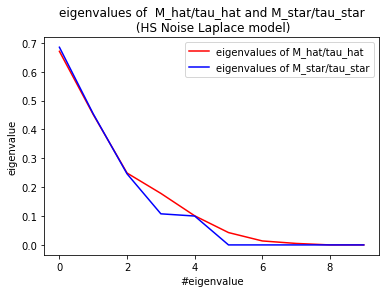

In [54]:
plt.plot(S_hat, label = 'eigenvalues of M_hat/tau_hat', color= 'red')
plt.plot(S_t, label = 'eigenvalues of M_star/tau_star', color = 'blue')
plt.legend()
plt.xlabel('#eigenvalue', fontsize=10)
plt.ylabel('eigenvalue', fontsize=10)
plt.title('eigenvalues of  M_hat/tau_hat and M_star/tau_star' + title_suffix, fontsize= 12)
plt.savefig(image_path + 'eigen')
plt.show()

In [55]:
# np.savetxt(csv_path + "eigen_S_star_normal.csv", 
#            S_t,
#            delimiter =", ", 
#            fmt ='% s')
np.savetxt(csv_path + "eigen.csv", 
           S_hat,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
H = []
m = 7
for i in range(m):
    H.append(proj(U_hat[:, i], U_t[:, :m]))
    
plt.plot([j+1 for j in range(m)], H, label = '1 - Cosine')
plt.legend()
plt.savefig(image_path + "Cosine")
plt.show()

In [ ]:
np.savetxt(csv_path + "Cosine.csv", 
           H,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
for i in range(d):
    print(np.dot(U_hat[:,i], U_t[:,i]))

In [ ]:
np.diag(U_hat.T @ U_t)

In [ ]:
I = model.epoch_history
plt.plot(I, model.train_accuracy_with_noise, label = 'train_accuracy_with_noise', color = 'black')
plt.plot(I, model.train_accuracy_without_noise, label = 'train_accuracy_without_noise', color = 'red')
plt.plot(I, model.test_accuracy_with_noise, label = 'test_accuracy_with_noise', color = 'green')
plt.plot(I, model.test_accuracy_without_noise, label = 'test_accuracy_without_noise', color = 'blue')
plt.legend()

plt.xlabel('epoch', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('Test and Train accuracy vs epochs' + title_suffix, fontsize=12)
plt.savefig(image_path + "Test_and_Train_accuracy_vs_epochs")
plt.show()

In [ ]:
np.savetxt(csv_path + "model_epoch_history.csv", 
           model.epoch_history,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
np.savetxt(csv_path + "model_train_accuracy_with_noise.csv", 
           model.train_accuracy_with_noise,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
np.savetxt(csv_path + "model_train_accuracy_without_noise.csv", 
           model.train_accuracy_without_noise,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
np.savetxt(csv_path + "model_test_accuracy_with_noise.csv", 
           model.test_accuracy_with_noise,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
np.savetxt(csv_path + "model_test_accuracy_without_noise.csv", 
           model.test_accuracy_without_noise,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
model.loss_history[-1].item()

In [ ]:
# loss(X_T - Y_T, D_T, model.B, model.Tau).item()
l_value = loss(X_T - Y_T, D_T, data_model.B_t/np.sqrt(s), data_model.tau_t/s, Type = model_type).item()
I_ = np.array([l_value for _ in I])

In [ ]:
plt.plot(I[:], model.loss_history[:], label = 'loss_history', color = 'blue')
plt.plot(I[:], I_[:], label = 'loss_on_M_star', color = 'red')
plt.legend()
plt.xlabel('# iteration', fontsize=10)
plt.ylabel('loss', fontsize=10)
plt.title('loss_history vs iteration' + title_suffix, fontsize=12)
plt.savefig(image_path + "loss_history_vs_iteration")
plt.show()

In [ ]:
np.savetxt(csv_path + "model.loss_history.csv", 
           model.loss_history,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
np.savetxt(csv_path + "true_loss_history.csv", 
           I_,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
model.L_1_f_norm_history[-1]

In [ ]:
plt.plot(I[:], model.L_1_f_norm_history[:], label = 'L_1_f_norm_history', color = 'blue')
plt.legend()
plt.xlabel('# iteration', fontsize=10)
plt.ylabel('norm_history', fontsize=10)
plt.title('L_1_f_norm_history vs iteration'+ title_suffix, fontsize=12)
plt.savefig(image_path + "_norm_history_vs_iteration")
plt.show()

In [ ]:
np.savetxt(csv_path + "model_L_1_f_norm_history.csv", 
           model.L_1_f_norm_history,
           delimiter =", ", 
           fmt ='% s')

## Sample complexity

In [ ]:
d = 10
k = 10
n_labels = len(tau)+1

In [ ]:
H = []
J = []
N = 0
while N <= 10000:
    if N < 100:
        N += 10
    elif N < 1000:
        N += 100
    elif N < 5000:
        N+= 1000
    else: N += 5000
    
    
    X, Y, D_noisy, D_no_noisy = data_model.generate(f, 
                                                    N + 2000, 
                                                    tau = np.array(tau), 
                                                    noise_type = noise_type, 
                                                    noise_par = std)
    X = torch.tensor(X, dtype = torch.float64)
    Y = torch.tensor(Y, dtype = torch.float64)
    D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
    D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)
        
    print('round for N = {} has started'.format(N))
    
    J.append(N)
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X, 
                                                                                                     Y, 
                                                                                                 D_noisy, 
                                                                                                 D_no_noisy, 
                                                                                                 n_train = N)
    model = ML(d, k, n_labels, 
               X_T, Y_T, 
               D_T, D_no_noise_T, 
               X_test, Y_test, 
               D_test, D_no_noise_test, Type = model_type) 
    
    model.train(learning_rate = 2e-1, 
                n_iters = 30000, 
                decay = .99, 
                show_log = False)
    H.append(model)

In [ ]:
H[-1].accuracy(X_new, Y_new, D_new)

In [ ]:
test_accuracy_no_noise  = [H[i].accuracy(X_new, Y_new, D_new) for i in range(len(H))]

In [ ]:
plt.plot(J, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('test_accuracy (no noise) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "test_accuracy_(no_noise)_vs_sample_complexity")
plt.show()

In [ ]:
np.savetxt(csv_path + "test_accuracy_no_noise.csv", 
           test_accuracy_no_noise,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
np.savetxt(csv_path + "number_samples_list.csv", 
           J,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
test_accuracy_noisy  = [H[i].accuracy(H[i].X_test, H[i].Y_test, H[i].D_test) for i in range(len(H))]

In [ ]:
plt.plot(J, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('test_accuracy (noisy) vs sample complexity'+ title_suffix, fontsize=10)
plt.savefig(image_path + 'test_accuracy_(noisy)_vs_sample_complexity')
plt.show()

In [ ]:
np.savetxt(csv_path + "test_accuracy_noisy.csv", 
           test_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
train_accuracy_noisy  = [H[i].accuracy(H[i].X_T, H[i].Y_T, H[i].D_T) for i in range(len(H))]

In [ ]:
plt.plot(J, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (noisy) vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "train_accuracy_(noisy)_vs_sample_complexity")
plt.show()

In [ ]:
np.savetxt(csv_path + "train_accuracy_noisy.csv", 
           train_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
train_accuracy_no_noisy  = [H[i].accuracy(H[i].X_T, H[i].Y_T, H[i].D_no_noise_T) for i in range(len(H))]

In [ ]:
plt.plot(J, train_accuracy_no_noisy, label = 'train_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('train_accuracy (no noise) vs sample complexity' +  title_suffix, fontsize=12)
plt.savefig(image_path + "train_accuracy_(no_noise)_vs_sample_complexity")
plt.show()

In [ ]:
np.savetxt(csv_path + "train_accuracy_no_noisy.csv", 
           train_accuracy_no_noisy,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
plt.plot(J, train_accuracy_no_noisy, label = 'train_accuracy (no noise)', color = 'blue')
plt.plot(J, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'red')
plt.plot(J, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'green')
plt.plot(J, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'magenta')

plt.legend()
plt.xlabel('# samples', fontsize=10)
plt.ylabel('accuracy', fontsize=10)
plt.title('accuracy vs sample complexity' + title_suffix, fontsize=12)
plt.savefig(image_path + "accuracy_vs_sample_complexity")
plt.show()

In [ ]:
I = H[-1].epoch_history[:]
plt.plot(I, H[-1].train_accuracy_with_noise[:], label = 'train_accuracy_with_noise', color = 'black')
plt.plot(I, H[-1].train_accuracy_without_noise[:], label = 'train_accuracy_without_noise', color = 'red')
plt.plot(I, H[-1].test_accuracy_with_noise[:], label = 'test_accuracy_with_noise', color = 'green')
plt.plot(I, H[-1].test_accuracy_without_noise[:], label = 'test_accuracy_without_noise', color = 'blue')
plt.legend()
plt.xlabel('# Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy vs Epoch' + title_suffix, fontsize=12)
plt.savefig(image_path + 'Accuracy_vs_Epoch')
plt.show()

### How much noise breaks the model!

In [ ]:
noise_par_list = [i/10 for i in range(11)] + [1+ i/5 for i in range(1,6)] + [2.5, 4, 50]

In [ ]:
std_list = [s_ * np.pi/np.sqrt(3) for s_ in noise_par_list]

In [ ]:
print(tau)
N = 20000

In [ ]:
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N = 20000, tau = np.array(tau), 
                                          noise_type = noise_type, noise_par = 40)
noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

In [ ]:
(D_no_noisy == 0).sum(), (D_no_noisy == 1).sum(), (D_no_noisy == 1).sum()/N

In [ ]:
# noise_par_list = [0, .2, .5, .8, 1.1, 1.4, 1.85, 2., 2.3, 2.5, 2.8, 2.9, 3.1,
#  3.9, 4.1, 4.35, 4.4, 4.5, 4.6, 4.8, 7.5, 12.5, 27, 60, 80, 150]

In [ ]:
# np.savetxt("CSVs/Gaussian/scale_list.csv", 
#            noise_par_list,
#            delimiter =", ", 
#            fmt ='% s')

In [ ]:
N=20000
d = 10
k = 10
n_labels = len(tau) + 1
noise_list_history = []
model_history = []
for std_ in std_list:
    X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                                    noise_type = noise_type, noise_par = std_)
    noise_amount = (D_noisy != D_no_noisy).mean()
    print('the amount of noise: {}'.format(noise_amount))
    noise_list_history.append(noise_amount)
    
    X = torch.tensor(X, dtype = torch.float64)
    Y = torch.tensor(Y, dtype = torch.float64)
    D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
    D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)
    
    X,Y,D,X_T, Y_T,D_T,D_no_noise_T, X_test,Y_test,D_test,D_no_noise_test = train_test_split(X,
                                                                                             Y, 
                                                                                             D_noisy, 
                                                                                             D_no_noisy,
                                                                                             n_train = 18000)
    model = ML(d, k, n_labels, 
               X_T, Y_T, D_T, D_no_noise_T,
               X_test, Y_test, D_test, D_no_noise_test, Type = model_type)
    
    model.train(learning_rate = 1e-1, 
                n_iters = 30001, 
                decay = .95, 
                show_log = False)
    
    model_history.append(model)
    
    print('train_accuracy (noisey) = {}'.format(model_history[-1].accuracy(model_history[-1].X_T, 
                                                                           model_history[-1].Y_T, 
                                                                           model_history[-1].D_T)))
    
    print('test_accuracy (noisey) = {}'.format(model_history[-1].accuracy(model_history[-1].X_test, 
                                                                          model_history[-1].Y_test, 
                                                                          model_history[-1].D_test)))
    
    print('train_accuracy (no noise) = {}'.format(model_history[-1].accuracy(model_history[-1].X_T, 
                                                                             model_history[-1].Y_T, 
                                                                             model_history[-1].D_no_noise_T)))
    
    print('test_accuracy (no noise) = {}'.format(model_history[-1].accuracy(model_history[-1].X_test, 
                                                                            model_history[-1].Y_test, 
                                                                            model_history[-1].D_no_noise_test)))
    print('\n')

In [ ]:
np.savetxt(csv_path + "noise_list_history.csv", 
           noise_list_history,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
plt.plot(noise_par_list, noise_list_history, label = 'variance VS noise', color = 'blue')
plt.legend()
plt.ylabel('# Noise', fontsize = 10)
plt.xlabel('variance', fontsize = 10)
plt.title('Noise vs variance [Gaussian]', fontsize = 10)
plt.show()

In [ ]:
X_new, Y_new, _, D_new = data_model.generate(f, 
                                             N = 10000, 
                                             tau = np.array(tau), 
                                             noise_type = None, 
                                             noise_par = None)
X_new = torch.tensor(X_new, dtype = torch.float64)
Y_new = torch.tensor(Y_new, dtype = torch.float64)
D_new = torch.tensor(D_new, dtype = torch.torch.int64)

In [ ]:
test_accuracy_no_noise  = [model_history[i].accuracy(X_new, Y_new, D_new) for i in range(len(model_history))]

plt.plot(noise_list_history, test_accuracy_no_noise, label = 'test_accuracy (no noise)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('test_accuracy (no noise) vs noise' + title_suffix, fontsize = 12)
plt.savefig(image_path + 'Test_accuracy_(no_noise)_vs_noise')
plt.show()

In [ ]:
np.savetxt(csv_path + "test_accuracy_no_noise.csv", 
           test_accuracy_no_noise,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
[(noise_list_history[i], test_accuracy_no_noise[i]) for i in range(len(noise_list_history))]

In [ ]:
test_accuracy_noisy  = [model_history[i].accuracy(model_history[i].X_test, 
                                                  model_history[i].Y_test, 
                                                  model_history[i].D_test) for i in range(len(model_history))]

plt.plot(noise_list_history, test_accuracy_noisy, label = 'test_accuracy(noisy)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('test_accuracy (noisy) vs noise' + title_suffix, fontsize = 12)
plt.savefig(image_path + 'test_accuracy_(noisy)_vs_noise')
plt.show()

In [ ]:
np.savetxt(csv_path + "test_accuracy_noisy.csv", 
           test_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
train_accuracy_noisy  = [model_history[i].accuracy(model_history[i].X_T, 
                                                   model_history[i].Y_T, 
                                                   model_history[i].D_T) for i in range(len(model_history))]

plt.plot(noise_list_history, train_accuracy_noisy, label = 'train_accuracy (noisy)', color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('train_accuracy (noisy) vs noise' + title_suffix, fontsize = 10)
plt.savefig(image_path + 'train_accuracy_(noisy)_vs_noise')
plt.show()

In [ ]:
np.savetxt(csv_path + "train_accuracy_noisy.csv", 
           train_accuracy_noisy,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
train_accuracy_no_noisy  = [model_history[i].accuracy(model_history[i].X_T, 
                                                      model_history[i].Y_T, 
                                                      model_history[i].D_no_noise_T) for i in range(len(model_history))]
plt.plot(noise_list_history, 
         train_accuracy_no_noisy, 
         label = 'train_accuracy (no noise)', 
         color = 'blue')
plt.legend()
plt.xlabel('noise', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('train_accuracy (no noise) vs noise' + title_suffix, fontsize = 12)
plt.savefig(image_path + 'train_accuracy_(no_noise)_vs_noise')
plt.show()

In [ ]:
np.savetxt(csv_path + "train_accuracy_no_noisy.csv", 
           train_accuracy_no_noisy,
           delimiter =", ", 
           fmt ='% s')

In [ ]:
noise_list_history[-1], train_accuracy_no_noisy[-1]